In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


[[[ 1.  1.  1. ...  9.  6.  4.]
  [ 1.  1.  1. ... 18. 12. 18.]
  [ 1.  1.  1. ... 33. 24. 24.]
  ...
  [ 1.  1.  1. ... 31. 28. 20.]
  [ 1.  1.  1. ... 20. 23. 20.]
  [ 1.  1.  1. ... 17.  7. 13.]]

 [[ 1.  1.  1. ...  5.  3.  3.]
  [ 1.  1.  1. ... 20. 15. 15.]
  [ 1.  1.  1. ... 32. 23. 23.]
  ...
  [ 1.  1.  1. ... 25. 32. 26.]
  [ 1.  1.  1. ... 31. 23. 23.]
  [ 1.  1.  1. ...  8.  5. 11.]]

 [[ 1.  1.  1. ...  3.  4.  4.]
  [ 1.  1.  1. ... 19. 14. 14.]
  [ 1.  1.  1. ... 25. 32. 23.]
  ...
  [ 1.  1.  1. ... 27. 27. 35.]
  [ 1.  1.  1. ... 18. 18. 24.]
  [ 1.  1.  1. ...  7.  7.  5.]]

 ...

 [[ 1.  1.  1. ...  2.  2.  2.]
  [ 1.  1.  1. ...  9.  6.  6.]
  [ 1.  1.  1. ... 16. 19. 24.]
  ...
  [ 1.  1.  1. ... 31. 37. 28.]
  [ 1.  1.  1. ... 25. 26. 14.]
  [ 1.  1.  1. ...  7.  4.  7.]]

 [[ 1.  1.  1. ...  5.  7.  5.]
  [ 1.  1.  1. ... 10. 13. 16.]
  [ 1.  1.  1. ... 26. 26. 23.]
  ...
  [ 1.  1.  1. ... 29. 35. 32.]
  [ 1.  1.  1. ... 14. 20. 14.]
  [ 1.  1.  1. ...  8.  8.  

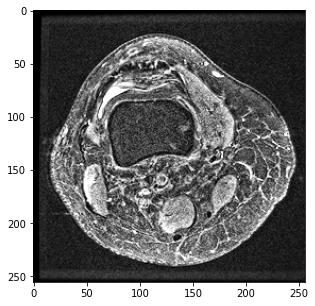

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, IntSlider
%matplotlib inline

train_dir = "/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/train"

mri_train = np.load(train_dir + '/axial/' + '0000.npy')

print(mri_train)

fig, ax1 = plt.subplots(1, 1, figsize=(15,5))

ax1.imshow(mri_train[10,:,:], 'gray')



In [7]:
import os
import numpy as np
import pandas as pd
%cd "/content/gdrive/My Drive/thesis/Data"

#csv import labels

train_ACL_labels = np.array(pd.read_csv("train-acl.csv", header=None).iloc[:,1])
train_abnormal_labels = np.array(pd.read_csv("train-abnormal.csv", header=None).iloc[:,1])
train_meniscus_labels = np.array(pd.read_csv("train-meniscus.csv", header=None).iloc[:,1])

valid_ACL_labels = np.array(pd.read_csv("valid-acl.csv", header=None).iloc[:,1])
valid_abnormal_labels = np.array(pd.read_csv("valid-abnormal.csv", header=None).iloc[:,1])
valid_meniscus_labels = np.array(pd.read_csv("valid-meniscus.csv", header=None).iloc[:,1])

test_ACL_labels = np.array(pd.read_csv("test-acl.csv", header=None).iloc[:,1])
test_abnormal_labels = np.array(pd.read_csv("test-abnormal.csv", header=None).iloc[:,1])
test_meniscus_labels = np.array(pd.read_csv("test-meniscus.csv", header=None).iloc[:,1])

#data path
train_path = "/content/gdrive/My Drive/thesis/Data/train"
train_axial_path = "/content/gdrive/My Drive/thesis/Data/train/coronal"

counter = 5
for filename in os.listdir(train_axial_path):
  if counter > 0:
    file0 = np.load(train_axial_path + '/' + filename)
    variancelist = []
    for slice in range(file0.shape[0]):
      variancelist.append(np.var(file0[slice,:,:]))
    #print(file0)
    #print('max', np.amax(file0))
    #print('mean', np.mean(file0))
    #print(filename, 'file shape', file0.shape, 'max_var_index', variancelist.index(max(variancelist)), max(variancelist))
    counter = counter - 1

print(valid_ACL_labels)
print("done!")

/content/gdrive/My Drive/thesis/Data
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 1 0 1 0]
done!


In [0]:
# model.py

import torch
import torch.nn as nn

from torchvision import models

class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.alexnet(pretrained=True)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(256, 1)

    # change this to adapt to different networks
    def forward(self, x):
        x = torch.squeeze(x, dim=0) # only batch size 1 supported
        x = self.model.features(x)
        # make sure that gap returns size 256
        x = self.gap(x).view(x.size(0), -1)
        x = torch.max(x, 0, keepdim=True)[0]
        x = self.classifier(x)
        return x

In [0]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, buffer=[[None, None, None] for _ in range(10)])
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss

class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
                    
        self.degenerated_to_sgd = degenerated_to_sgd
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)


                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif self.degenerated_to_sgd:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = scheduled_lr * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss

In [0]:
import argparse
import json
import numpy as np
import os
import torch
from datetime import datetime
from pathlib import Path
from sklearn import metrics

def train(rundir, diagnosis, orientation, epochs, learning_rate, transformbool, use_gpu):
    
    val_auc_array = list()
    train_auc_array = list()
    test_auc_array = list()
    train_loader, valid_loader, test_loader = load_data(diagnosis, orientation, transformbool, use_gpu)
    
    model = MRNet()

    if use_gpu:
        model = model.cuda()

    optimizer = RAdam(model.parameters(), learning_rate, weight_decay=.01)

    # patience too low (after 5 epochs, if AUC hasnt improved, slash learning rate .3), which is why high learning rate seems to work better
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=.3, threshold=1e-4)

    best_val_loss = float('inf')

    start_time = datetime.now()

    for epoch in range(epochs):
        change = datetime.now() - start_time
        print('starting epoch {}. time passed: {}'.format(epoch+1, str(change)))
        
        train_loss, train_auc, _, _ = run_model(model, train_loader, train=True, optimizer=optimizer)
        #print(f'train loss: {train_loss:0.4f}')
        #print(f'train AUC: {train_auc:0.4f}')

        val_loss, val_auc, _, _ = run_model(model, valid_loader)
        #print(f'valid loss: {val_loss:0.4f}')
        #print(f'valid AUC: {val_auc:0.4f}')

        test_loss, test_auc, _, _ = run_model(model, test_loader)

        val_auc_array.append(val_auc)
        train_auc_array.append(train_auc)
        test_auc_array.append(test_auc)
        
        scheduler.step(val_loss)
  
    
    file_name = f'val{val_auc:0.4f}_train{train_auc:0.4f}_test{test_auc:0.4f}_epoch{epoch+1}'
    save_path = "/content/gdrive/My Drive/thesis/Results/models" + '/' + str(diagnosis) + '/' + str(orientation) + "/" + file_name
    torch.save(model.state_dict(), save_path)
    print('model saved at', str(save_path))
        
    return val_auc_array, train_auc_array, test_auc_array

In [11]:
# loader.py

!pip install medicaltorch
!pip install clahe


import numpy as np
import os
import pickle
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from medicaltorch import transforms as mt_transforms
import PIL
from random import sample
import cv2
import clahe

from torch.autograd import Variable

INPUT_DIM = 224
MAX_PIXEL_VAL = 255
#MEAN = 58.09
#STDDEV = 49.73

class Dataset(data.Dataset):
    def __init__(self, datadirs, diagnosis, orientation, use_gpu, transformbool):
        super().__init__()
        self.use_gpu = use_gpu
        self.transformbool = transformbool
        label_dict = {}
        self.paths = []
        print(datadirs)
        
        self.orientation = orientation
        self.diagnosis = diagnosis

        train_string = "/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/train"
        valid_string = "/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/valid"
        test_string = "/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/test"

        if datadirs == train_string:
          if diagnosis == 'ACL':
            self.labels = train_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = train_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = train_abnormal_labels
        if datadirs == valid_string:
          if diagnosis == 'ACL':
            self.labels = valid_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = valid_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = valid_abnormal_labels
        if datadirs == test_string:
          if diagnosis == 'ACL':
            self.labels = test_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = test_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = test_abnormal_labels

        direct = datadirs + '/' + self.orientation
        for file in os.listdir(direct):
          self.paths.append(direct + '/' + file)
        self.paths.sort()

        #print("paths", self.paths[0:10])

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]

        print(self.labels.shape)
        print(self.weights)

    def weighted_loss(self, prediction, target):
        weights_npy = np.array([self.weights[int(t[0])] for t in target.data])
        weights_tensor = torch.FloatTensor(weights_npy)
        if self.use_gpu:
            weights_tensor = weights_tensor.cuda()
        loss = F.binary_cross_entropy_with_logits(prediction, target, weight=Variable(weights_tensor))
        return loss

    # Data augmentation section
    # can go through each cases, looking at the histogram of 3T vs 1.5T (naive distribution of contrast data?)
    def __getitem__(self, index):
        path = self.paths[index]
        
        vol = np.load(path)
        """
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        for sliceindex in range(vol.shape[0]):
            print(vol[sliceindex])
            PIL.Image.fromarray(vol[sliceindex]).show()
            vol[sliceindex] = np.array(clahe.apply(PIL.Image.fromarray(np.array(vol[sliceindex]))))
        """
        
        ax_mean = 63.16
        ax_std = 60.46
        cor_mean = 59.27
        cor_std = 64.00
        sag_mean = 58.25
        sag_std = 48.15
        
        # standardize
        vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol) + 1.0e-6) * MAX_PIXEL_VAL

        if self.orientation == 'axial':
          MEAN = ax_mean
          STDDEV = ax_std
        if self.orientation == 'coronal':
          MEAN = cor_mean
          STDDEV = cor_std
        if self.orientation == 'sagittal':
          MEAN = sag_mean
          STDDEV = sag_std    

        vol = (vol - MEAN) / STDDEV
        vol = vol.astype(np.float32)

        flag = False
        randomangle = 0

        # define transform policy
        hor_flip = np.random.rand(1)
        ran_rot = np.random.rand(1)
        randomangle = np.random.uniform(-20, 20)
        uni_noise = np.random.rand(1)
        ran_trans = np.random.rand(1)
        persp = np.random.rand(1)

        """
        if ran_rot < 0.5:
          randomangle = 0
        """
        trans = 0
        if ran_trans < 0.5:
          trans = 0.05

        if self.transformbool:
          #if np.random.rand(1) < 0.5:
          flag = True

          
          if uni_noise < 0.5:
            noise_array = np.random.uniform(0.95,1.05,256*256)
            noise_array.resize((256,256))
            
            vol = np.multiply(vol, noise_array)
            vol = np.clip(vol, 0, 255)
            vol = vol.astype(np.float32)
          

          self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.RandomHorizontalFlip(p=(hor_flip < 0.5)), 
            torchvision.transforms.RandomAffine((randomangle,randomangle), translate = (trans,trans), resample=PIL.Image.BILINEAR),
            torchvision.transforms.RandomPerspective(distortion_scale=0.3, p=(persp<0.3)),
            torchvision.transforms.ToTensor()
        ])

        if flag:
          for sliceindex in range(vol.shape[0]):
            vol[sliceindex] = self.transforms(np.array(vol[sliceindex]))

        vol = np.stack((vol,)*3, axis=1)
        vol_tensor = torch.FloatTensor(vol)
        label_tensor = torch.FloatTensor([self.labels[index]])

        return vol_tensor, label_tensor

    def __len__(self):
        return len(self.paths)

def load_data(diagnosis, orientation, transformbool, use_gpu=True):

    print('load_data', diagnosis, orientation)

    train_path = "/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/train"
    valid_path = "/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/valid"
    test_path = "/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/test"

    batchsize = 1
    numworkers = 8
    
    #assert(1==2)
    #train_dataset = Dataset(train_dirs, diagnosis, use_gpu)
    train_dataset = Dataset(train_path, diagnosis, orientation, use_gpu, transformbool)
    valid_dataset = Dataset(valid_path, diagnosis, orientation, use_gpu, False)
    test_dataset = Dataset(test_path, diagnosis, orientation, use_gpu, False)

    train_loader = data.DataLoader(train_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=True)
    valid_loader = data.DataLoader(valid_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    test_loader = data.DataLoader(test_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    return train_loader, valid_loader, test_loader


In [0]:
# evaluate.py

import argparse
import matplotlib.pyplot as plt
import os
import numpy as np
import torch

from sklearn import metrics
from torch.autograd import Variable

#from loader import load_data
#from model import MRNet

def get_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_path', type=str, required=True)
    parser.add_argument('--split', type=str, required=True)
    parser.add_argument('--diagnosis', type=int, required=True)
    parser.add_argument('--gpu', action='store_true')
    return parser

def run_model(model, loader, train=False, optimizer=None):
    preds = []
    labels = []

    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.
    num_batches = 0

    for batch in loader:
        if train:
            optimizer.zero_grad()

        vol, label = batch
        if loader.dataset.use_gpu:
            vol = vol.cuda()
            label = label.cuda()
        vol = Variable(vol)
        label = Variable(label)

        logit = model.forward(vol)

        loss = loader.dataset.weighted_loss(logit, label)
        total_loss += loss.item()

        #
        pred = torch.sigmoid(logit)
        pred_npy = pred.data.cpu().numpy()[0][0]
        label_npy = label.data.cpu().numpy()[0][0]

        preds.append(pred_npy)
        labels.append(label_npy)

        if train:
            loss.backward()
            optimizer.step()
        num_batches += 1

    avg_loss = total_loss / num_batches

    fpr, tpr, threshold = metrics.roc_curve(labels, preds)
    auc = metrics.auc(fpr, tpr)

    return avg_loss, auc, preds, labels

def evaluate(split, model_path, diagnosis, orientation, use_gpu):
    train_loader, valid_loader, test_loader = load_data(diagnosis, orientation, transformbool, use_gpu)
    model = MRNet()
    state_dict = torch.load(model_path, map_location=(None if use_gpu else 'cpu'))
    model.load_state_dict(state_dict)

    if use_gpu:
        model = model.cuda()

    if split == 'train':
        loader = train_loader
    elif split == 'valid':
        loader = valid_loader
    elif split == 'test':
        loader = test_loader
    else:
        raise ValueError("split must be 'train', 'valid', or 'test'")

    loss, auc, preds, labels = run_model(model, loader)

    print(f'{split} loss: {loss:0.4f}')
    print(f'{split} AUC: {auc:0.4f}')

    return preds, labels

#if __name__ == '__main__':
#    args = get_parser().parse_args()
#   evaluate(args.split, args.model_path, args.diagnosis, args.gpu)

In [0]:
import matplotlib
matplotlib.use('Agg')
gpu = True
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

#learningrate = 5e-05
epochs = 100
#diagnosis = 'ACL'
rundir = "/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/"
#orientation = 'axial'
savedir = "/content/gdrive/My Drive/thesis/Results/round4"


if gpu:
  torch.cuda.manual_seed_all(seed)

def display_single(x_length, lr1, varray, tarray, testarray, title, xlabel, ylabel, save_dir):
  plt.figure(0)
  plt.ylim(0.0,1.0)
  plt.title(title)
  plt.plot(np.arange(x_length), varray, label='valid')
  plt.plot(np.arange(x_length), tarray, label='train')
  plt.plot(np.arange(x_length), testarray, label='test')
  plt.legend()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.savefig(save_dir + '/' + title + '.eps', format='eps')
  plt.show()
  plt.close()
  return

In [0]:
#ax w/ aug
aug = True
epochs = 50
diagnosis = 'ACL'
orientation = 'axial'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'CLAHE_8_8_2 alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + " + noise", 'epoch', 'AUC', savedir)

In [0]:
#ax w/ aug
aug = True
epochs = 50
diagnosis = 'ACL'
orientation = 'sagittal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'CLAHE alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + " + noise", 'epoch', 'AUC', savedir)

load_data ACL sagittal
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/test
(130,)
[0.15384615384615385, 0.8461538461538461]
starting epoch 1. time passed: 0:00:00.000062
starting epoch 2. time passed: 0:04:27.410380
starting epoch 3. time passed: 0:07:44.760545
starting epoch 4. time passed: 0:10:50.121197
starting epoch 5. time passed: 0:14:01.178304
starting epoch 6. time passed: 0:16:55.420086
starting epoch 7. time passed: 0:19:51.776914
starting epoch 8. time passed: 0:23:29.428117
starting epoch 9. time passed: 0:26:18.544480
starting epoch 10. time passed: 0:29:38.115923
starting epoch 11. time passed: 0:32:41.118309
starting epoch 12. time passed: 0:35:50.749325
starting epoch 13. time passed: 0:38:59.773298
starting epoch 14. time passed: 0:42:18.964899
starting epoch 15. time passed: 0:45:57.601102
starting epoch 16. time p

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [0]:
#ax w/ aug
aug = True
epochs = 50
diagnosis = 'ACL'
orientation = 'coronal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'CLAHE alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + " + noise", 'epoch', 'AUC', savedir)

load_data ACL coronal
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/test
(130,)
[0.15384615384615385, 0.8461538461538461]
starting epoch 1. time passed: 0:00:00.000013
starting epoch 2. time passed: 0:03:58.628374
starting epoch 3. time passed: 0:07:07.659776
starting epoch 4. time passed: 0:10:01.029703
starting epoch 5. time passed: 0:12:51.669252
starting epoch 6. time passed: 0:15:58.830800
starting epoch 7. time passed: 0:18:49.366451
starting epoch 8. time passed: 0:22:00.251613
starting epoch 9. time passed: 0:24:55.006930
starting epoch 10. time passed: 0:27:57.713167
starting epoch 11. time passed: 0:30:51.477916
starting epoch 12. time passed: 0:34:00.097426
starting epoch 13. time passed: 0:37:04.677061
starting epoch 14. time passed: 0:39:50.049518
starting epoch 15. time passed: 0:42:49.551190
starting epoch 16. time pa

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


model saved at /content/gdrive/My Drive/thesis/Results/models/ACL/coronal/val0.8740_train0.9966_test0.7705_epoch50


In [0]:
#ax w/ aug
aug = True
epochs = 50
diagnosis = 'meniscus'
orientation = 'axial'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'CLAHE_8_8_2 alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + " + noise", 'epoch', 'AUC', savedir)

load_data meniscus axial
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/train
(1000,)
[0.355, 0.645]
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/valid
(120,)
[0.43333333333333335, 0.5666666666666667]
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/test
(130,)
[0.3230769230769231, 0.676923076923077]


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



starting epoch 1. time passed: 0:00:00.000009
starting epoch 2. time passed: 0:04:15.223554
starting epoch 3. time passed: 0:08:23.597411
starting epoch 4. time passed: 0:12:13.491329
starting epoch 5. time passed: 0:16:06.540214
starting epoch 6. time passed: 0:20:00.477649
starting epoch 7. time passed: 0:23:53.289405
starting epoch 8. time passed: 0:27:51.209440
starting epoch 9. time passed: 0:31:38.890930
starting epoch 10. time passed: 0:35:38.720654
starting epoch 11. time passed: 0:39:33.854053
starting epoch 12. time passed: 0:43:30.940379
starting epoch 13. time passed: 0:47:25.547216
starting epoch 14. time passed: 0:51:19.669068
starting epoch 15. time passed: 0:55:18.434585
starting epoch 16. time passed: 0:59:08.484508
starting epoch 17. time passed: 1:03:08.174248
starting epoch 18. time passed: 1:06:59.670083
starting epoch 19. time passed: 1:10:58.826441
starting epoch 20. time passed: 1:14:44.369063
starting epoch 21. time passed: 1:18:44.071111
starting epoch 22. ti

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [0]:
#ax w/ aug
aug = True
epochs = 50
diagnosis = 'meniscus'
orientation = 'sagittal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'CLAHE_8_8_2 alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + " + noise", 'epoch', 'AUC', savedir)

load_data meniscus sagittal
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/train
(1000,)
[0.355, 0.645]
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/valid
(120,)
[0.43333333333333335, 0.5666666666666667]
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/test
(130,)
[0.3230769230769231, 0.676923076923077]
starting epoch 1. time passed: 0:00:00.000010
starting epoch 2. time passed: 0:04:05.476656
starting epoch 3. time passed: 0:07:08.705211
starting epoch 4. time passed: 0:10:16.210863
starting epoch 5. time passed: 0:13:19.173784
starting epoch 6. time passed: 0:16:23.027704
starting epoch 7. time passed: 0:19:26.903276
starting epoch 8. time passed: 0:23:12.850445
starting epoch 9. time passed: 0:26:03.685968
starting epoch 10. time passed: 0:29:21.041509
starting epoch 11. time passed: 0:32:22.478059
starting epoch 12. time passed: 0:35:36.420961
starting epoch 13. time passed: 0:38:48.836188
starting epoch 14. time passed: 0:41:51.780000
starting epoch 15. time passed: 0:45:06.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


model saved at /content/gdrive/My Drive/thesis/Results/models/meniscus/sagittal/val0.7528_train0.9738_test0.6929_epoch50


In [0]:
#ax w/ aug
aug = True
epochs = 50
diagnosis = 'meniscus'
orientation = 'coronal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'CLAHE_8_8_2 alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + " + noise", 'epoch', 'AUC', savedir)

load_data meniscus coronal
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/train
(1000,)
[0.355, 0.645]
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/valid
(120,)
[0.43333333333333335, 0.5666666666666667]
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/test
(130,)
[0.3230769230769231, 0.676923076923077]


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



starting epoch 1. time passed: 0:00:00.000014
starting epoch 2. time passed: 0:03:40.487814
starting epoch 3. time passed: 0:06:38.013416
starting epoch 4. time passed: 0:09:37.756173
starting epoch 5. time passed: 0:12:32.521577
starting epoch 6. time passed: 0:15:29.997637
starting epoch 7. time passed: 0:18:23.159503
starting epoch 8. time passed: 0:21:25.538848
starting epoch 9. time passed: 0:24:22.243250
starting epoch 10. time passed: 0:27:08.431434
starting epoch 11. time passed: 0:30:06.669589
starting epoch 12. time passed: 0:33:05.844409
starting epoch 13. time passed: 0:36:01.187679
starting epoch 14. time passed: 0:39:00.978286
starting epoch 15. time passed: 0:41:56.014664
starting epoch 16. time passed: 0:44:51.911200
starting epoch 17. time passed: 0:48:06.810115
starting epoch 18. time passed: 0:50:58.286734
starting epoch 19. time passed: 0:53:51.245261
starting epoch 20. time passed: 0:56:57.015701
starting epoch 21. time passed: 0:59:45.760556
starting epoch 22. ti

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [0]:
#ax w/ aug
aug = True
epochs = 50
diagnosis = 'abnormal'
orientation = 'axial'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'CLAHE_8_8_2 alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + " + noise", 'epoch', 'AUC', savedir)

load_data abnormal axial
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/train
(1000,)
[0.812, 0.18799999999999994]
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/valid
(120,)
[0.7916666666666666, 0.20833333333333337]
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/test
(130,)
[0.7769230769230769, 0.22307692307692306]
starting epoch 1. time passed: 0:00:00.000014
starting epoch 2. time passed: 0:04:45.005773
starting epoch 3. time passed: 0:08:43.072952
starting epoch 4. time passed: 0:12:31.139706
starting epoch 5. time passed: 0:16:24.545642
starting epoch 6. time passed: 0:20:20.607181
starting epoch 7. time passed: 0:24:11.566218
starting epoch 8. time passed: 0:28:02.367810
starting epoch 9. time passed: 0:32:06.032715
starting epoch 10. time passed: 0:36:00.371197
starting epoch 11. time passed: 0:39:48.759897
starting epoch 12. time passed: 0:43:47.493173
starting epoch 13. time passed: 0:47:48.459636
starting epoch 14. time passed: 0:51:44.961061
starting epoch 15. time pas

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


model saved at /content/gdrive/My Drive/thesis/Results/models/abnormal/axial/val0.9318_train0.9912_test0.8832_epoch50


In [0]:
#ax w/ aug
aug = True
epochs = 50
diagnosis = 'abnormal'
orientation = 'sagittal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'CLAHE_8_8_2 alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + " + noise", 'epoch', 'AUC', savedir)

load_data abnormal sagittal
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/train
(1000,)
[0.812, 0.18799999999999994]
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/valid
(120,)
[0.7916666666666666, 0.20833333333333337]
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/test
(130,)
[0.7769230769230769, 0.22307692307692306]
starting epoch 1. time passed: 0:00:00.000028
starting epoch 2. time passed: 0:04:09.855244
starting epoch 3. time passed: 0:07:16.480109
starting epoch 4. time passed: 0:10:18.075744
starting epoch 5. time passed: 0:13:31.613329
starting epoch 6. time passed: 0:16:35.092787
starting epoch 7. time passed: 0:19:45.338231
starting epoch 8. time passed: 0:22:54.986539
starting epoch 9. time passed: 0:25:59.429253
starting epoch 10. time passed: 0:29:07.390459
starting epoch 11. time passed: 0:32:17.178311
starting epoch 12. time passed: 0:35:29.072845
starting epoch 13. time passed: 0:38:35.608960
starting epoch 14. time passed: 0:41:47.322262
starting epoch 15. time 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


model saved at /content/gdrive/My Drive/thesis/Results/models/abnormal/sagittal/val0.9402_train0.9915_test0.8856_epoch50


In [0]:
#ax w/ aug
aug = True
epochs = 50
diagnosis = 'abnormal'
orientation = 'coronal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'CLAHE_8_8_2 alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + " + noise", 'epoch', 'AUC', savedir)

load_data abnormal coronal
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/train
(1000,)
[0.812, 0.18799999999999994]
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/valid
(120,)
[0.7916666666666666, 0.20833333333333337]
/content/gdrive/My Drive/thesis/Data/CLAHE_8_8_2/test
(130,)
[0.7769230769230769, 0.22307692307692306]
starting epoch 1. time passed: 0:00:00.000023
starting epoch 2. time passed: 0:02:06.784548
starting epoch 3. time passed: 0:05:00.434323
starting epoch 4. time passed: 0:08:04.469593
starting epoch 5. time passed: 0:10:52.253387
starting epoch 6. time passed: 0:13:52.263738
starting epoch 7. time passed: 0:16:59.664597
starting epoch 8. time passed: 0:19:46.852230
starting epoch 9. time passed: 0:22:43.628059
starting epoch 10. time passed: 0:25:45.703401
starting epoch 11. time passed: 0:28:32.987269
starting epoch 12. time passed: 0:31:37.553996
starting epoch 13. time passed: 0:34:39.156261
starting epoch 14. time passed: 0:37:30.976000
starting epoch 15. time p

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [14]:
# loader.py

!pip install medicaltorch
!pip install clahe


import numpy as np
import os
import pickle
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from medicaltorch import transforms as mt_transforms
import PIL
from random import sample
import cv2
import clahe

from torch.autograd import Variable

INPUT_DIM = 224
MAX_PIXEL_VAL = 255
#MEAN = 58.09
#STDDEV = 49.73

class Dataset(data.Dataset):
    def __init__(self, datadirs, diagnosis, orientation, use_gpu, transformbool):
        super().__init__()
        self.use_gpu = use_gpu
        self.transformbool = transformbool
        label_dict = {}
        self.paths = []
        print(datadirs)
        
        self.orientation = orientation
        self.diagnosis = diagnosis

        train_string = "/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/train"
        valid_string = "/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/valid"
        test_string = "/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/test"

        if datadirs == train_string:
          if diagnosis == 'ACL':
            self.labels = train_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = train_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = train_abnormal_labels
        if datadirs == valid_string:
          if diagnosis == 'ACL':
            self.labels = valid_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = valid_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = valid_abnormal_labels
        if datadirs == test_string:
          if diagnosis == 'ACL':
            self.labels = test_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = test_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = test_abnormal_labels

        direct = datadirs + '/' + self.orientation
        for file in os.listdir(direct):
          self.paths.append(direct + '/' + file)
        self.paths.sort()

        #print("paths", self.paths[0:10])

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]

        print(self.labels.shape)
        print(self.weights)

    def weighted_loss(self, prediction, target):
        weights_npy = np.array([self.weights[int(t[0])] for t in target.data])
        weights_tensor = torch.FloatTensor(weights_npy)
        if self.use_gpu:
            weights_tensor = weights_tensor.cuda()
        loss = F.binary_cross_entropy_with_logits(prediction, target, weight=Variable(weights_tensor))
        return loss

    # Data augmentation section
    # can go through each cases, looking at the histogram of 3T vs 1.5T (naive distribution of contrast data?)
    def __getitem__(self, index):
        path = self.paths[index]
        
        vol = np.load(path)
        """
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        for sliceindex in range(vol.shape[0]):
            print(vol[sliceindex])
            PIL.Image.fromarray(vol[sliceindex]).show()
            vol[sliceindex] = np.array(clahe.apply(PIL.Image.fromarray(np.array(vol[sliceindex]))))
        """
        
        ax_mean = 63.16
        ax_std = 60.46
        cor_mean = 59.27
        cor_std = 64.00
        sag_mean = 58.25
        sag_std = 48.15
        
        # standardize
        vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol) + 1.0e-6) * MAX_PIXEL_VAL

        if self.orientation == 'axial':
          MEAN = ax_mean
          STDDEV = ax_std
        if self.orientation == 'coronal':
          MEAN = cor_mean
          STDDEV = cor_std
        if self.orientation == 'sagittal':
          MEAN = sag_mean
          STDDEV = sag_std    

        vol = (vol - MEAN) / STDDEV
        vol = vol.astype(np.float32)

        flag = False
        randomangle = 0

        # define transform policy
        hor_flip = np.random.rand(1)
        ran_rot = np.random.rand(1)
        randomangle = np.random.uniform(-20, 20)
        uni_noise = np.random.rand(1)
        ran_trans = np.random.rand(1)
        persp = np.random.rand(1)

        """
        if ran_rot < 0.5:
          randomangle = 0
        """
        trans = 0
        if ran_trans < 0.5:
          trans = 0.05

        if self.transformbool:
          #if np.random.rand(1) < 0.5:
          flag = True

          
          if uni_noise < 0.5:
            noise_array = np.random.uniform(0.95,1.05,256*256)
            noise_array.resize((256,256))
            
            vol = np.multiply(vol, noise_array)
            vol = np.clip(vol, 0, 255)
            vol = vol.astype(np.float32)
          

          self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.RandomHorizontalFlip(p=(hor_flip < 0.5)), 
            torchvision.transforms.RandomAffine((randomangle,randomangle), translate = (trans,trans), resample=PIL.Image.BILINEAR),
            torchvision.transforms.RandomPerspective(distortion_scale=0.3, p=(persp<0.3)),
            torchvision.transforms.ToTensor()
        ])

        if flag:
          for sliceindex in range(vol.shape[0]):
            vol[sliceindex] = self.transforms(np.array(vol[sliceindex]))

        vol = np.stack((vol,)*3, axis=1)
        vol_tensor = torch.FloatTensor(vol)
        label_tensor = torch.FloatTensor([self.labels[index]])

        return vol_tensor, label_tensor

    def __len__(self):
        return len(self.paths)

def load_data(diagnosis, orientation, transformbool, use_gpu=True):

    print('load_data', diagnosis, orientation)

    train_path = "/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/train"
    valid_path = "/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/valid"
    test_path = "/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/test"

    batchsize = 1
    numworkers = 8
    
    #assert(1==2)
    #train_dataset = Dataset(train_dirs, diagnosis, use_gpu)
    train_dataset = Dataset(train_path, diagnosis, orientation, use_gpu, transformbool)
    valid_dataset = Dataset(valid_path, diagnosis, orientation, use_gpu, False)
    test_dataset = Dataset(test_path, diagnosis, orientation, use_gpu, False)

    train_loader = data.DataLoader(train_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=True)
    valid_loader = data.DataLoader(valid_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    test_loader = data.DataLoader(test_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    return train_loader, valid_loader, test_loader


In [0]:
rundir = "/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/"

In [0]:
#ax w/ aug
aug = True
epochs = 50
diagnosis = 'ACL'
orientation = 'axial'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'CLAHE_16_16_2 alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + " + noise", 'epoch', 'AUC', savedir)

load_data ACL axial
/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/test
(130,)
[0.15384615384615385, 0.8461538461538461]
starting epoch 1. time passed: 0:00:00.000013
starting epoch 2. time passed: 0:04:20.828973
starting epoch 3. time passed: 0:08:10.707578
starting epoch 4. time passed: 0:12:13.367461
starting epoch 5. time passed: 0:16:01.957019
starting epoch 6. time passed: 0:19:53.152421
starting epoch 7. time passed: 0:23:41.037033
starting epoch 8. time passed: 0:27:40.635375
starting epoch 9. time passed: 0:31:33.543063
starting epoch 10. time passed: 0:35:31.954660
starting epoch 11. time passed: 0:39:13.227558
starting epoch 12. time passed: 0:43:22.740637
starting epoch 13. time passed: 0:47:16.596667
starting epoch 14. time passed: 0:51:20.285643
starting epoch 15. time passed: 0:55:30.004273
starting epoch 16. tim

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [0]:
#ax w/ aug
aug = True
epochs = 50
diagnosis = 'ACL'
orientation = 'sagittal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'CLAHE_16_16_2 alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + " + noise", 'epoch', 'AUC', savedir)

load_data ACL sagittal
/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/test
(130,)
[0.15384615384615385, 0.8461538461538461]
starting epoch 1. time passed: 0:00:00.000014
starting epoch 2. time passed: 0:03:56.867911
starting epoch 3. time passed: 0:07:03.465034
starting epoch 4. time passed: 0:10:10.320406
starting epoch 5. time passed: 0:13:16.667669
starting epoch 6. time passed: 0:16:33.998318
starting epoch 7. time passed: 0:19:36.328368
starting epoch 8. time passed: 0:22:45.763273
starting epoch 9. time passed: 0:25:58.685647
starting epoch 10. time passed: 0:29:05.359214
starting epoch 11. time passed: 0:32:14.144936
starting epoch 12. time passed: 0:35:29.444477
starting epoch 13. time passed: 0:38:29.633386
starting epoch 14. time passed: 0:41:45.395963
starting epoch 15. time passed: 0:44:50.922681
starting epoch 16. 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


model saved at /content/gdrive/My Drive/thesis/Results/models/ACL/sagittal/val0.9108_train0.9902_test0.8027_epoch50


In [16]:
#ax w/ aug
aug = True
epochs = 50
diagnosis = 'ACL'
orientation = 'coronal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'CLAHE_16_16_2 alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + " + noise", 'epoch', 'AUC', savedir)

load_data ACL coronal
/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/test
(130,)
[0.15384615384615385, 0.8461538461538461]


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



starting epoch 1. time passed: 0:00:00.000013
starting epoch 2. time passed: 0:03:41.919734
starting epoch 3. time passed: 0:06:40.005519
starting epoch 4. time passed: 0:09:30.345879
starting epoch 5. time passed: 0:12:28.642279
starting epoch 6. time passed: 0:15:29.288308
starting epoch 7. time passed: 0:18:29.010418
starting epoch 8. time passed: 0:21:29.147361
starting epoch 9. time passed: 0:24:26.708196
starting epoch 10. time passed: 0:27:13.218635
starting epoch 11. time passed: 0:30:08.707064
starting epoch 12. time passed: 0:33:32.375703
starting epoch 13. time passed: 0:36:13.853986
starting epoch 14. time passed: 0:39:08.602590
starting epoch 15. time passed: 0:42:08.638014
starting epoch 16. time passed: 0:44:57.780451
starting epoch 17. time passed: 0:47:54.555528
starting epoch 18. time passed: 0:51:01.261231
starting epoch 19. time passed: 0:53:54.359502
starting epoch 20. time passed: 0:56:52.729933
starting epoch 21. time passed: 0:59:59.314569
starting epoch 22. ti

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [17]:
#ax w/ aug
aug = True
epochs = 50
diagnosis = 'meniscus'
orientation = 'axial'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'CLAHE_16_16_2 alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + " + noise", 'epoch', 'AUC', savedir)

load_data meniscus axial
/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/train
(1000,)
[0.355, 0.645]
/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/valid
(120,)
[0.43333333333333335, 0.5666666666666667]
/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/test
(130,)
[0.3230769230769231, 0.676923076923077]
starting epoch 1. time passed: 0:00:00.000016
starting epoch 2. time passed: 0:04:44.600188
starting epoch 3. time passed: 0:08:22.299663
starting epoch 4. time passed: 0:12:31.777962
starting epoch 5. time passed: 0:16:14.719655
starting epoch 6. time passed: 0:20:10.061612
starting epoch 7. time passed: 0:24:08.989795
starting epoch 8. time passed: 0:28:07.817738
starting epoch 9. time passed: 0:32:02.448935
starting epoch 10. time passed: 0:35:48.657488
starting epoch 11. time passed: 0:39:43.400971
starting epoch 12. time passed: 0:43:47.670315
starting epoch 13. time passed: 0:47:49.460682
starting epoch 14. time passed: 0:51:38.407260
starting epoch 15. time passed: 0:55:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [18]:
#ax w/ aug
aug = True
epochs = 50
diagnosis = 'meniscus'
orientation = 'sagittal'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'CLAHE_16_16_2 alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + " + noise", 'epoch', 'AUC', savedir)

load_data meniscus sagittal
/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/train
(1000,)
[0.355, 0.645]
/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/valid
(120,)
[0.43333333333333335, 0.5666666666666667]
/content/gdrive/My Drive/thesis/Data/CLAHE_16_16_2/test
(130,)
[0.3230769230769231, 0.676923076923077]
starting epoch 1. time passed: 0:00:00.000012
starting epoch 2. time passed: 0:04:11.528821
starting epoch 3. time passed: 0:07:10.923747
starting epoch 4. time passed: 0:10:22.152208
starting epoch 5. time passed: 0:13:24.974728
starting epoch 6. time passed: 0:16:41.930605
starting epoch 7. time passed: 0:19:49.631160
starting epoch 8. time passed: 0:22:53.665610
starting epoch 9. time passed: 0:26:02.628566
starting epoch 10. time passed: 0:29:19.304644
starting epoch 11. time passed: 0:32:24.141404
starting epoch 12. time passed: 0:35:34.686361
starting epoch 13. time passed: 0:38:45.311484
starting epoch 14. time passed: 0:41:53.679574
starting epoch 15. time passed: 0:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


model saved at /content/gdrive/My Drive/thesis/Results/models/meniscus/sagittal/val0.7398_train0.9340_test0.7208_epoch50


Change Transforms


In [0]:
# loader.py

!pip install medicaltorch

import numpy as np
import os
import pickle
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from medicaltorch import transforms as mt_transforms
import PIL
from random import sample

from torch.autograd import Variable

INPUT_DIM = 224
MAX_PIXEL_VAL = 255
#MEAN = 58.09
#STDDEV = 49.73

class Dataset(data.Dataset):
    def __init__(self, datadirs, diagnosis, orientation, use_gpu, transformbool):
        super().__init__()
        self.use_gpu = use_gpu
        self.transformbool = transformbool
        label_dict = {}
        self.paths = []
        print(datadirs)
        
        self.orientation = orientation
        self.diagnosis = diagnosis

        train_string = "/content/gdrive/My Drive/thesis/Data/train"
        valid_string = "/content/gdrive/My Drive/thesis/Data/valid"
        test_string = "/content/gdrive/My Drive/thesis/Data/test"

        if datadirs == train_string:
          if diagnosis == 'ACL':
            self.labels = train_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = train_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = train_abnormal_labels
        if datadirs == valid_string:
          if diagnosis == 'ACL':
            self.labels = valid_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = valid_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = valid_abnormal_labels
        if datadirs == test_string:
          if diagnosis == 'ACL':
            self.labels = test_ACL_labels
          if diagnosis == 'meniscus':
            self.labels = test_meniscus_labels
          if diagnosis == 'abnormal':
            self.labels = test_abnormal_labels

        direct = datadirs + '/' + self.orientation
        for file in os.listdir(direct):
          self.paths.append(direct + '/' + file)
        self.paths.sort()

        #print("paths", self.paths[0:10])

        neg_weight = np.mean(self.labels)
        self.weights = [neg_weight, 1 - neg_weight]

        print(self.labels.shape)
        print(self.weights)

    def weighted_loss(self, prediction, target):
        weights_npy = np.array([self.weights[int(t[0])] for t in target.data])
        weights_tensor = torch.FloatTensor(weights_npy)
        if self.use_gpu:
            weights_tensor = weights_tensor.cuda()
        loss = F.binary_cross_entropy_with_logits(prediction, target, weight=Variable(weights_tensor))
        return loss

    # Data augmentation section
    # can go through each cases, looking at the histogram of 3T vs 1.5T (naive distribution of contrast data?)
    def __getitem__(self, index):
        path = self.paths[index]
        
        vol = np.load(path)

        
        ax_mean = 63.16
        ax_std = 60.46
        cor_mean = 59.27
        cor_std = 64.00
        sag_mean = 58.25
        sag_std = 48.15
        

        # standardize
        vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol) + 1.0e-6) * MAX_PIXEL_VAL
        
        
        if self.orientation == 'axial':
          MEAN = ax_mean
          STDDEV = ax_std
        if self.orientation == 'coronal':
          MEAN = cor_mean
          STDDEV = cor_std
        if self.orientation == 'sagittal':
          MEAN = sag_mean
          STDDEV = sag_std
        

        vol = (vol - MEAN) / STDDEV

        vol = vol.astype(np.float32)

        flag = False
        randomangle = 0
        trans = 0

        # define transform policy
        hor_flip = np.random.rand(1)
        ran_rot = np.random.rand(1)
        randomangle = np.random.uniform(-20, 20)
        #uni_noise = np.random.rand(1)
        ran_trans = np.random.rand(1)
        persp = np.random.rand(1)
        rand_erase = np.random.rand(1)

        if ran_trans < 0.5:
          trans = 0.05
        if ran_rot < 0.5:
          randomangle = 0
        
        if self.transformbool:
          #if np.random.rand(1) < 0.5:
          flag = True

          #try random noise by default, 30% chance gaussian, 30% normal, 40% speckle?
          #if uni_noise < 0.5:
          noise_array = np.random.uniform(0.95,1.05,256*256)
          noise_array.resize((256,256))
          
          vol = np.multiply(vol, noise_array)
          vol = np.clip(vol, 0, 255)
          vol = vol.astype(np.float32)
          
          self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.RandomHorizontalFlip(p=(hor_flip < 0.5)), 
            torchvision.transforms.RandomAffine((randomangle,randomangle), translate=(trans,trans), resample=PIL.Image.BILINEAR),
            torchvision.transforms.RandomPerspective(distortion_scale=0.3, p=(persp < 0.3)),
            torchvision.transforms.ToTensor(),
            #torchvision.transforms.RandomErasing(p=(rand_erase < 0.2),scale=(0.02, 0.33), ratio=(0.3, 3.3))
        ])

        if flag:
          for sliceindex in range(vol.shape[0]):
            vol[sliceindex] = self.transforms(np.array(vol[sliceindex]))

        vol = np.stack((vol,)*3, axis=1)
        vol_tensor = torch.FloatTensor(vol)
        label_tensor = torch.FloatTensor([self.labels[index]])

        return vol_tensor, label_tensor

    def __len__(self):
        return len(self.paths)

def load_data(diagnosis, orientation, transformbool, use_gpu=True):

    print('load_data', diagnosis, orientation)

    train_path = "/content/gdrive/My Drive/thesis/Data/train"
    valid_path = "/content/gdrive/My Drive/thesis/Data/valid"
    test_path = "/content/gdrive/My Drive/thesis/Data/test"

    batchsize = 1
    numworkers = 8
    
    #assert(1==2)
    #train_dataset = Dataset(train_dirs, diagnosis, use_gpu)
    train_dataset = Dataset(train_path, diagnosis, orientation, use_gpu, transformbool)
    valid_dataset = Dataset(valid_path, diagnosis, orientation, use_gpu, False)
    test_dataset = Dataset(test_path, diagnosis, orientation, use_gpu, False)

    train_loader = data.DataLoader(train_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=True)
    valid_loader = data.DataLoader(valid_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    test_loader = data.DataLoader(test_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False)
    return train_loader, valid_loader, test_loader


In [0]:
import matplotlib
matplotlib.use('Agg')
gpu = True
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

#learningrate = 5e-05
epochs = 100
#diagnosis = 'ACL'
rundir = "/content/gdrive/My Drive/thesis/Data"
#orientation = 'axial'
savedir = "/content/gdrive/My Drive/thesis/Results/round3"


if gpu:
  torch.cuda.manual_seed_all(seed)

def display_single(x_length, lr1, varray, tarray, testarray, title, xlabel, ylabel, save_dir):
  plt.figure(0)
  plt.title(title)
  plt.ylim(0.0,1.0)
  plt.plot(np.arange(x_length), varray, label='valid')
  plt.plot(np.arange(x_length), tarray, label='train')
  plt.plot(np.arange(x_length), testarray, label='test')
  plt.legend()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.savefig(save_dir + '/' + title + '.eps', format='eps')
  plt.show()
  plt.close()
  return

In [0]:
#ax w/ aug
aug = True
epochs = 50
diagnosis = 'ACL'
orientation = 'axial'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'alexnet RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + " + new transforms", 'epoch', 'AUC', savedir)

load_data ACL axial
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.15384615384615385, 0.8461538461538461]
starting epoch 1. time passed: 0:00:00.000010
starting epoch 2. time passed: 0:02:19.934219
starting epoch 3. time passed: 0:03:41.137049
starting epoch 4. time passed: 0:05:03.651072
starting epoch 5. time passed: 0:06:25.778070
starting epoch 6. time passed: 0:07:47.868397
starting epoch 7. time passed: 0:09:09.612851
starting epoch 8. time passed: 0:10:31.898019
starting epoch 9. time passed: 0:11:54.853636
starting epoch 10. time passed: 0:13:17.478472
starting epoch 11. time passed: 0:14:40.339306
starting epoch 12. time passed: 0:16:03.458072
starting epoch 13. time passed: 0:17:26.424681
starting epoch 14. time passed: 0:18:49.026480
starting epoch 15. time passed: 0:20:12.229687
starting epoch 16. time passed: 0:21:34.224628
starting epoch 17

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


model saved at /content/gdrive/My Drive/thesis/Results/models/ACL/axial/val0.9231_train0.9964_test0.8582_epoch50


In [0]:
# model.py

import torch
import torch.nn as nn

from torchvision import models

class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.vgg11_bn(pretrained=True)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(512, 1)

    # change this to adapt to different networks
    def forward(self, x):
        x = torch.squeeze(x, dim=0) # only batch size 1 supported
        x = self.model.features(x)
        # make sure that gap returns size 256
        x = self.gap(x).view(x.size(0), -1)
        x = torch.max(x, 0, keepdim=True)[0]
        x = self.classifier(x)
        return x

In [0]:
#ax w/ aug
aug = True
epochs = 50
diagnosis = 'ACL'
orientation = 'axial'
lr = 1e-05
varray1, tarray1, testarray1 = train(rundir, diagnosis, orientation, epochs, lr, aug, gpu)
title = 'vgg11_bn RAdam ' + diagnosis + ' ' + orientation + ' lr = ' + str(lr)
display_single(epochs, lr, varray1, tarray1, testarray1, title + ' aug = ' + str(aug) + " + new transforms", 'epoch', 'AUC', savedir)

load_data ACL axial
/content/gdrive/My Drive/thesis/Data/train
(1000,)
[0.188, 0.812]
/content/gdrive/My Drive/thesis/Data/valid
(120,)
[0.45, 0.55]
/content/gdrive/My Drive/thesis/Data/test
(130,)
[0.15384615384615385, 0.8461538461538461]


Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/checkpoints/vgg11_bn-6002323d.pth



starting epoch 1. time passed: 0:00:00.000012
starting epoch 2. time passed: 0:04:21.170130
starting epoch 3. time passed: 0:08:32.897080
starting epoch 4. time passed: 0:12:44.756275
starting epoch 5. time passed: 0:16:56.379318
starting epoch 6. time passed: 0:21:08.191492
starting epoch 7. time passed: 0:25:19.969348
starting epoch 8. time passed: 0:29:31.754513
starting epoch 9. time passed: 0:33:43.445059
starting epoch 10. time passed: 0:37:55.332559
starting epoch 11. time passed: 0:42:06.969957
starting epoch 12. time passed: 0:46:18.879517
starting epoch 13. time passed: 0:50:30.471466
starting epoch 14. time passed: 0:54:42.293248
starting epoch 15. time passed: 0:58:54.117705
starting epoch 16. time passed: 1:03:06.395435
starting epoch 17. time passed: 1:07:18.317010
starting epoch 18. time passed: 1:11:30.130288
starting epoch 19. time passed: 1:15:42.037986
starting epoch 20. time passed: 1:19:53.774395
starting epoch 21. time passed: 1:24:05.337946
starting epoch 22. ti

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


model saved at /content/gdrive/My Drive/thesis/Results/models/ACL/axial/val0.8799_train0.9988_test0.8164_epoch50
